# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import scipy

from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Read updated *Nikos* data

In [2]:
xls = pd.ExcelFile('data/edited_nikos_data.xlsx')
xls.sheet_names

['ANAMET',
 'Anamet data',
 'ISRI',
 'Isri data',
 'UNS data',
 'Elements data',
 'Material data',
 'Process']

In [3]:
uns_data = pd.read_excel(xls, 'UNS data')

uns_data.rename(columns = {'sc:isComposedOf':'elements id'}, inplace = True)

elements_data = pd.read_excel(xls, 'Elements data')

uns_data = pd.merge(uns_data, elements_data, how='inner', on = 'elements id')
isri_data = pd.read_excel(xls, 'Isri data')
anamet_data = pd.read_excel(xls, 'Anamet data')
material_data = pd.read_excel(xls, 'Material data')
elements_data = pd.read_excel(xls, 'Elements data')

# Raw data preprocessing

In [4]:
isri_data.head(2)

,isri id,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasISRICode,sc:hasSpecification,pc:hasName,sc:isComposedOf,sc:isProcessedBy
0,sc:ISRI_0,Nonferrous Scrap - Red Metals,Wire,NaN,Copper,Berry,"Bare, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257
1,sc:ISRI_1,Nonferrous Scrap - Red Metals,Wire and Cable,"Brittle Burnt Wire, Copper Tubing",Copper,Barley,"Clean, Untinned, Uncoated, Unalloyed",No. 1 Copper Wire,sc:Material_249,sc:Process_257


In [5]:
isri_data.shape

(244, 10)

In [6]:
isri_data.isna().sum()

isri id                  0
sc:hasCategory           0
sc:hasForm              43
sc:isFreeFrom           87
sc:contains             68
sc:hasISRICode           0
sc:hasSpecification     12
pc:hasName               7
sc:isComposedOf        109
sc:isProcessedBy       194
dtype: int64

#### Drop unusefull columns

In [7]:
df = isri_data.copy()
df.drop(columns=['isri id', 'sc:hasISRICode', 'sc:isProcessedBy'], inplace=True)
df.shape

(244, 7)

In [8]:
import texthero as hero
from texthero import preprocessing

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords]

for col in df.drop('sc:isComposedOf',axis=1).columns:
    df[col] = hero.clean(df[col])

df.head()


,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasSpecification,pc:hasName,sc:isComposedOf
0,nonferrous scrap red metals,wire,,copper,bare uncoated unalloyed,copper wire,sc:Material_249
1,nonferrous scrap red metals,wire cable,brittle burnt wire copper tubing,copper,clean untinned uncoated unalloyed,copper wire,sc:Material_249
2,nonferrous scrap red metals,miscellaneous wire,excessively leaded tinned soldered copper wire...,copper,unalloyed,copper wire,sc:Material_249
3,nonferrous scrap red metals,clippings punchings bus bars commutator segmen...,,copper,clean unalloyed uncoated,heavy copper solids tubing,sc:Material_249
4,nonferrous scrap red metals,miscellaneous scrap,excessively leaded tinned soldered copper scra...,copper,unalloyed,copper solids tubing,sc:Material_249


In [9]:
df.isna().sum()

sc:hasCategory           0
sc:hasForm               0
sc:isFreeFrom            0
sc:contains              0
sc:hasSpecification      0
pc:hasName               0
sc:isComposedOf        109
dtype: int64

## Predict `sc:isComposedOf`

#### TfIdfVectorizer

In [11]:
df = df[df['sc:isComposedOf'].notna()]
df.shape

(135, 7)

In [12]:
# df['corpus'] = df['sc:hasCategory'] + ' ' + df['sc:hasSpecification'] + ' ' + df['sc:hasForm'] + df['sc:contains'] + ' ' + df['pc:hasName']
# df['corpus'] = df['sc:hasSpecification'] + ' ' + df['sc:hasForm'] + df['sc:contains']
df['corpus'] = df['sc:hasSpecification'] + ' ' + df['sc:hasForm'] + df['sc:contains'] + ' ' + df['pc:hasName']

In [13]:
df.head(2)

,sc:hasCategory,sc:hasForm,sc:isFreeFrom,sc:contains,sc:hasSpecification,pc:hasName,sc:isComposedOf,corpus
0,nonferrous scrap red metals,wire,,copper,bare uncoated unalloyed,copper wire,sc:Material_249,bare uncoated unalloyed wirecopper copper wire
1,nonferrous scrap red metals,wire cable,brittle burnt wire copper tubing,copper,clean untinned uncoated unalloyed,copper wire,sc:Material_249,clean untinned uncoated unalloyed wire cableco...


In [14]:
from sklearn.model_selection import train_test_split

X = df['corpus']
y = df['sc:isComposedOf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

y_train = y_train.values
y_test = y_test.values

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print(train_vectors.shape, test_vectors.shape)

(108, 521) (27, 521)


####  Logistic Regression

In [15]:
model = LogisticRegression()

model.fit(train_vectors, y_train)
predicted = model.predict(test_vectors)
print(accuracy_score(y_test,predicted))

results = pd.DataFrame(columns=['true', 'pred'])
results['true'] = y_test
results['pred'] = predicted

0.4074074074074074


#### SVC

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'kernel': ('linear', 'rbf') , 
              'C':[5, 10, 12, 15, 20, 25],
              'gamma': [1,0.1,0.2, 0.3, 0.5, 0.01,0.001]
             }
grid = GridSearchCV(SVC(random_state=42) , param_grid , refit=True , verbose=0, cv=5)
grid.fit(train_vectors, y_train)
print(grid.best_estimator_)

model_svc = grid.best_estimator_
predicted = model_svc.predict(test_vectors)
print(accuracy_score(y_test,predicted))

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


SVC(C=5, gamma=1, kernel='linear', random_state=42)
0.8518518518518519


#### KNN

In [46]:
# from sklearn.neighbors import KNeighborsClassifier

# model = KNeighborsClassifier()
# model.fit(train_vectors, y_train)
# predicted = model.predict(test_vectors)
# print(accuracy_score(y_test, predicted))

# n_neighbors = list(range(1,20))
# p=[1,2]#Convert to dictionary
# param_grid = dict(n_neighbors=n_neighbors, p=p)

# grid = GridSearchCV(model , param_grid , refit=True , verbose=0, cv=3)
# grid.fit(train_vectors, y_train)
# print(grid.best_estimator_)

# model = grid.best_estimator_
# predicted = model.predict(test_vectors)
# print(accuracy_score(y_test,predicted))

0.5555555555555556


/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


KNeighborsClassifier(n_neighbors=9)
0.5185185185185185


#### Random Forest Classifier

In [19]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

# model = RandomForestClassifier()

# model.fit(train_vectors, y_train)
# predicted = model.predict(test_vectors)
# print(accuracy_score(y_test,predicted))

# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]# Create the random grid

# param_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# grid = RandomizedSearchCV(model , param_grid , refit=True , verbose=0, cv=3, n_iter=20)
# grid.fit(train_vectors, y_train)
# print(grid.best_estimator_)

# model = grid.best_estimator_
# predicted = model.predict(test_vectors)
# print(accuracy_score(y_test,predicted))

0.5185185185185185


/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_split=5,
                       n_estimators=1000)
0.6296296296296297


#### Gaussian Process Classifier

In [16]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

model = GaussianProcessClassifier()
model.fit(train_vectors.todense(), y_train)
predicted = model.predict(test_vectors.todense())
print(accuracy_score(y_test,predicted))

grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
# define search
grid = GridSearchCV(model, grid, scoring='accuracy', cv=3, n_jobs=-1)
grid.fit(train_vectors.todense(), y_train)

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.3333333333333333


/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/v

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/g

GridSearchCV(cv=3, estimator=GaussianProcessClassifier(), n_jobs=-1,
             param_grid={'kernel': [1**2 * RBF(length_scale=1),
                                    1**2 * DotProduct(sigma_0=1),
                                    1**2 * Matern(length_scale=1, nu=1.5),
                                    1**2 * RationalQuadratic(alpha=1, length_scale=1),
                                    1**2 * WhiteKernel(noise_level=1)]},
             scoring='accuracy')

In [17]:
model_gp=grid.best_estimator_
model_gp

GaussianProcessClassifier(kernel=1**2 * DotProduct(sigma_0=1))

In [18]:
predicted = model_gp.predict(test_vectors.todense())
print(accuracy_score(y_test,predicted))

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.8148148148148148


#### Train best model on all `ISRI` dataset

In [20]:
vectors = vectorizer.transform(X)
print(vectors.shape)

(135, 489)


In [21]:
model_gp.fit(vectors.todense(), y)

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessClassifier(kernel=1**2 * DotProduct(sigma_0=1))

In [24]:
predicted = model_gp.predict(test_vectors.todense())
print(accuracy_score(y_test,predicted))

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.9629629629629629


The high accuracy is because we using the model to predict a part of the training set.

We will try to predict the material that `ANAMET` scraps are composed using the models trained on `ISRI` dataset

#### Keep only `ANAMET` with english `sc:description`

In [17]:
anamet_data = pd.read_excel(xls, 'Anamet data')

In [18]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]
anamet_data.head(2)

,anamet entity,sc:description,sc:hasCategory,sc:internal_code,sc:isProcessedBy
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.,Non-Ferrous,40014,NaN
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING,Non-Ferrous,40015,NaN


In [19]:
anamet_data.shape

(214, 5)

In [20]:
anamet_data = anamet_data[['anamet entity', 'sc:description', 'sc:hasCategory']]
anamet_data = anamet_data[['anamet entity', 'sc:description']]

anamet_data.head(2)

,anamet entity,sc:description
28,sc:ANAMET_465,COPPER SCRAP MILLBERRY CABLES FOR STRIP.
30,sc:ANAMET_466,COPPER SCRAP BIRCH CABLES FOR STRIPPING


In [21]:
anamet_data.isna().sum()

anamet entity     0
sc:description    0
dtype: int64

In [22]:
for col in anamet_data.drop('anamet entity', axis=1).columns:
    anamet_data[col] = hero.clean(anamet_data[col])

anamet_data.head(2)

,anamet entity,sc:description
28,sc:ANAMET_465,copper scrap millberry cables strip
30,sc:ANAMET_466,copper scrap birch cables stripping


In [23]:
anamet_data_X = pd.DataFrame()
# anamet_data_X['corpus'] = anamet_data['sc:description'] + ' ' + anamet_data['sc:hasCategory']
anamet_data_X['corpus'] = anamet_data['sc:description']

In [24]:
X = anamet_data_X['corpus']

anamet_train_vectors = vectorizer.transform(X)

print(anamet_train_vectors.shape)

(214, 521)


In [25]:
model = model_svc
y_hat = model.predict(anamet_train_vectors.todense())

/home/comex/Desktop/python-envs/main-bio/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [26]:
anamet_data['predicted material'] = y_hat

pd.set_option('display.max_rows', 300)
anamet_data

,anamet entity,sc:description,predicted material
28,sc:ANAMET_465,copper scrap millberry cables strip,sc:Material_249
30,sc:ANAMET_466,copper scrap birch cables stripping,sc:Material_249
33,sc:ANAMET_467,mixed copper cables scrap raw,sc:Material_249
34,sc:ANAMET_468,cables copper lead raw,sc:Material_249
37,sc:ANAMET_469,copper scrap berry candy per isr raw,sc:Material_249
38,sc:ANAMET_470,scrap ms raw,sc:Material_244
41,sc:ANAMET_471,brass scrap honey per isri raw,sc:Material_256
43,sc:ANAMET_472,aluminum scrap taint tabor raw material,sc:Material_244
45,sc:ANAMET_473,aluminum scrap mixed raw material,sc:Material_244
47,sc:ANAMET_474,aluminum scrap shred raw material,sc:Material_244


In [27]:
pd.DataFrame(y_hat).value_counts()

sc:Material_244    128
sc:Material_249     33
sc:Material_256     19
sc:Material_701     13
sc:Material_695      7
sc:Material_697      5
sc:Material_700      3
sc:Material_703      2
sc:Material_704      2
sc:Material_252      1
sc:Material_253      1
dtype: int64

# Study `UNS`

In [34]:
uns_data

,uns id,sc:hasName,elements id,ar,atomicNumber,density,meltingPoint,hasName,symbol
0,sc:UNS_712,C83300,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
1,sc:UNS_733,C84500,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
2,sc:UNS_738,C85310,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
3,sc:UNS_752,C85710,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
4,sc:UNS_837,C91500,sc:Elements_329,207.200,82,11.29,327.5,LEAD,Pb
...,...,...,...,...,...,...,...,...,...
907,sc:UNS_1657,C50200,sc:Elements_943,32.605,16,2.07,112.8,SULFUR,S
908,sc:UNS_1305,NaN,sc:Elements_943,32.605,16,2.07,112.8,SULFUR,S
909,sc:UNS_1654,NaN,sc:Elements_943,32.605,16,2.07,112.8,SULFUR,S
910,sc:UNS_1767,C70280,sc:Elements_946,10.811,5,2.34,2076.0,BORON,B


In [35]:
uns_data.drop('sc:hasName', axis=1, inplace=True)

In [36]:
uns_data.isna().sum()

uns id          0
elements id     0
ar              0
atomicNumber    0
density         0
meltingPoint    0
hasName         0
symbol          0
dtype: int64

In [37]:
print(uns_data['uns id'].nunique(), "unique UNS-type scraps.")

912 unique UNS-type scraps.


In [38]:
print(uns_data['hasName'].nunique())
print(uns_data['hasName'].unique())

25
['LEAD' 'COPPER' 'TIN' 'NICKEL' 'ZINC' 'MANGANESE' 'IRON' 'BISMUTH'
 'ALUMINUM' 'ANTIMONY' 'SILICON' 'MAGNESIUM' 'SILVER' 'CHROMIUM'
 'BERYLLIUM' 'PHOSPHORUS' 'ARSENIC' 'COBALT' 'ZIRCONIUM' 'CARBON'
 'TITANIUM' 'OXYGEN' 'CADMIUM' 'SULFUR' 'BORON']


In [39]:
elements_data

,elements id,ar,atomicNumber,density,meltingPoint,hasName,symbol
0,sc:Elements_319,63.546000,29,8.960,1085.00,COPPER,Cu
1,sc:Elements_320,47.867000,22,4.500,1668.00,TITANIUM,Ti
2,sc:Elements_321,55.845000,26,7.874,1538.00,IRON,Fe
3,sc:Elements_322,26.981539,13,2.700,660.30,ALUMINUM,Al
4,sc:Elements_323,24.305000,12,1.738,650.00,MAGNESIUM,Mg
5,sc:Elements_324,6.941000,3,534.000,180.50,LITHIUM,Li
6,sc:Elements_325,186.207000,75,21.020,3185.00,RHENIUM,Re
7,sc:Elements_326,118.710000,50,5.750,231.90,TIN,Sn
8,sc:Elements_327,58.693400,28,8.902,1455.00,NICKEL,Ni
9,sc:Elements_328,65.380000,30,7.130,419.50,ZINC,Zn


### Clustering on `UNS` types

In [40]:
uns_data.drop(columns=['elements id', 'hasName', 'symbol'], inplace=True)

In [41]:
uns_data.head(2)

,uns id,ar,atomicNumber,density,meltingPoint
0,sc:UNS_712,207.2,82,11.29,327.5
1,sc:UNS_733,207.2,82,11.29,327.5


In [42]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

uns_data['uns id'] = label_enc.fit_transform(uns_data['uns id'])
uns_data.head(2)

,uns id,ar,atomicNumber,density,meltingPoint
0,679,207.2,82,11.29,327.5
1,700,207.2,82,11.29,327.5


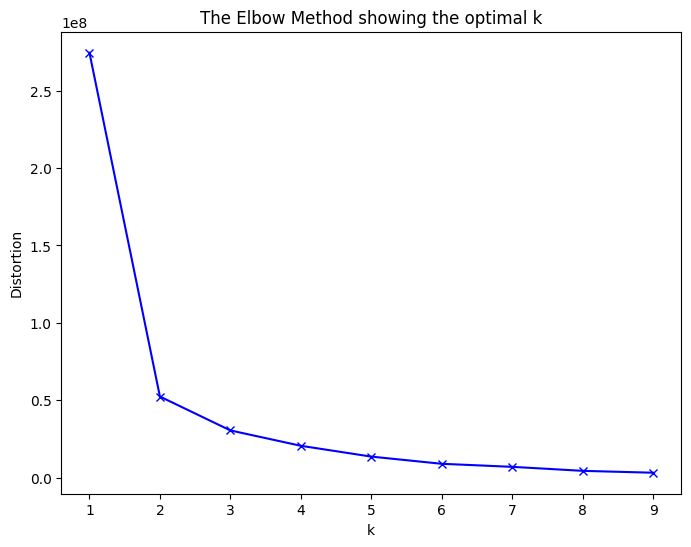

In [43]:
from sklearn.cluster import KMeans

df = uns_data.drop('uns id', axis=1).copy()

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [44]:
opt_k = 3
kmeans = KMeans(n_clusters=opt_k)
kmeans.fit(df)

KMeans(n_clusters=3)

In [45]:
uns_data['cluster'] = kmeans.labels_

In [46]:
uns_data

,uns id,ar,atomicNumber,density,meltingPoint,cluster
0,679,207.200,82,11.29,327.5,0
1,700,207.200,82,11.29,327.5,0
2,705,207.200,82,11.29,327.5,0
3,719,207.200,82,11.29,327.5,0
4,804,207.200,82,11.29,327.5,0
...,...,...,...,...,...,...
907,372,32.605,16,2.07,112.8,0
908,29,32.605,16,2.07,112.8,0
909,369,32.605,16,2.07,112.8,0
910,481,10.811,5,2.34,2076.0,1


# Study `ANAMET`

In [ ]:
anamet_data

# Unified dataset

In [ ]:
uns_data = pd.read_excel(xls, 'UNS data')

uns_data.rename(columns = {'sc:isComposedOf':'elements id'}, inplace = True)

elements_data = pd.read_excel(xls, 'Elements data')

uns_data = pd.merge(uns_data, elements_data, how='inner', on = 'elements id')
isri_data = pd.read_excel(xls, 'Isri data')
anamet_data = pd.read_excel(xls, 'Anamet data')
material_data = pd.read_excel(xls, 'Material data')
elements_data = pd.read_excel(xls, 'Elements data')

How many __unique__ ISRI?

In [ ]:
isri_data['isri id'].nunique()

In [ ]:
# check nans
isri_data.isna().sum()

Όσα `ISRI` έχουν available `process`, ανήκουν στο ίδιο. Επομένως, δεν έχει νοήμα η προσπάθεια πρόβλεψης του process κάποιου scrap.

In [ ]:
print(isri_data['sc:isProcessedBy'].unique())

# drop process from ISRI
isri_data.drop('sc:isProcessedBy', axis=1, inplace=True)

In [ ]:
isri_data['sc:hasCategory'].value_counts()

In [ ]:
isri_data.head(2)

#### Check for NaNs and fill them with empty string

In [ ]:
isri_data.isna().sum()

In [ ]:
# isri_data.fillna('', inplace=True)

In [ ]:
# Probably just a 'code name'. We will drop it
isri_data.drop('sc:hasISRICode', axis=1, inplace=True)

In [ ]:
isri_data.head(2)

# TDS: How to vectorize text in DF for NLP

In [ ]:
import texthero as hero
from texthero import preprocessing

In [ ]:
custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords]

df = isri_data.copy()

In [ ]:
df.head()

In [ ]:
reviews = df['sc:hasCategory'].str.cat(sep=' ')

In [ ]:
le = LabelEncoder()

df['sc:isComposedOf'] = le.fit_transform(df['sc:isComposedOf'])
df.head(2)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop('sc:isComposedOf', axis=1)
y = df['sc:isComposedOf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = X_train['sc:hasCategory'].values
X_test = X_test['sc:hasCategory'].values

y_train = y_train.values
y_test = y_test.values

vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

print(train_vectors.shape, test_vectors.shape)

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(train_vectors, y_train)
predicted = clf.predict(test_vectors)
print(accuracy_score(y_test,predicted))

In [ ]:
pd.DataFrame(train_vectors.todense())

In [ ]:
train_vectors.todense()

In [ ]:
for col in X_train.columns:
    vectorizer = TfidfVectorizer()
    train_vectors = vectorizer.fit_tr
    print(col)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

X = df['sc:hasCategory']

cvec = CountVectorizer().fit(X)
X = cvec.transform(X)
df_train = pd.DataFrame(X.todense(), columns=cvec.get_feature_names())
df_train

In [ ]:
for col in df.drop('sc:isComposedOf', axis=1).columns:
    df[col] = hero.clean(df[col])
    df[col] = df[col].pipe(hero.clean, custom_pipeline)

df.head()


In [ ]:
for col in df.drop('sc:isComposedOf', axis=1).columns:
    df[col] = hero.tfidf(df[col])

df.head()

In [ ]:
print(df.isna().sum())

df.fillna('', inplace=True)

In [ ]:
pred_isComposedOf_df = df[df['sc:isComposedOf'] != '']
pred_isComposedOf_df.shape


In [ ]:
le = LabelEncoder()

pred_isComposedOf_df['sc:isComposedOf'] = le.fit_transform(pred_isComposedOf_df['sc:isComposedOf'])
pred_isComposedOf_df.head(2)

In [ ]:
from sklearn.model_selection import train_test_split

X = pred_isComposedOf_df.drop('sc:isComposedOf', axis=1)
y = pred_isComposedOf_df['sc:isComposedOf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression())

model.fit(X_train['sc:hasCategory'], y_train)
y_hat = model.predict(X_test)

results = pd.DataFrame()

results['true'] = y_test
results['pred'] = y_hat

accuracy_score(y_test, y_hat)

In [ ]:
pred_isComposedOf_df = isri_data[isri_data['sc:isComposedOf'] != '']
pred_isComposedOf_df.drop(columns=['isri id', 'sc:isFreeFrom'], inplace=True)
pred_isComposedOf_df.head()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# columns = ['sc:hasCategory', 'pc:hasName']
columns = pred_isComposedOf_df.columns

for col_name in columns:
    
    if col_name == 'sc:isComposedOf': continue
    else:
            
        text = isri_data[col_name]

        df = pd.DataFrame()
        df['corpus'] = text
        df['cleaned'] = df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

        pred_isComposedOf_df[col_name] = df['cleaned']

        del df

In [ ]:
pred_isComposedOf_df

In [ ]:
def cluster_text(text, true_k):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(text)

    return X

   #  Sum_of_squared_distances = []
   #  K = range(2,10)
   #  for k in K:
   #     km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   #     km = km.fit(X)
   #     Sum_of_squared_distances.append(km.inertia_)
   #  plt.plot(K, Sum_of_squared_distances, 'bx-')
   #  plt.xlabel('k')
   #  plt.ylabel('Sum_of_squared_distances')
   #  plt.title('Elbow Method For Optimal k')
   #  plt.show()

   # #  true_k = 6
   #  model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
   #  model.fit(X)

   #  labels=model.labels_
   #  clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
   #  #print(clusters.sort_values(by=['cluster']))
       
   #  return clusters

In [ ]:
X = cluster_text(pred_isComposedOf_df['sc:hasCategory'], 6)
X.shape

In [ ]:
for mat in pred_isComposedOf_df['sc:isComposedOf'].value_counts().tail(15).index.values:

    pred_isComposedOf_df = pred_isComposedOf_df[pred_isComposedOf_df['sc:isComposedOf'] != mat]

In [ ]:
from sklearn.model_selection import train_test_split

X = pred_isComposedOf_df.drop('sc:isComposedOf', axis=1)
y = pred_isComposedOf_df['sc:isComposedOf']

X = cluster_text(X['sc:hasCategory'], 6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

model = OneVsRestClassifier(LogisticRegression())

model.fit(X_train, y_train)
y_hat = model.predict(X_test)

results = pd.DataFrame()

results['true'] = y_test
results['pred'] = y_hat

accuracy_score(y_test, y_hat)

In [ ]:
isri_data['cluster_category'] = cluster_text(isri_data['sc:hasCategory'], 6)['cluster']
isri_data.head(2)

In [ ]:
isri_data['cluster_hasName'] = cluster_text(isri_data['pc:hasName'], 5)['cluster']
isri_data.head(2)

In [ ]:
 isri_data[isri_data['cluster_hasName'] == 1]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MultiLabelBinarizer

df = pred_isComposedOf_df.copy()
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['sc:isComposedOf'])
Y = multilabel_binarizer.transform(df['sc:isComposedOf'])

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(df['sc:hasCategory'])

tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)


In [ ]:
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, Y, 
                    test_size=0.2, random_state=2)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test_tfidf)))
    print("Hamming score: {}".format(hamming_score(y_pred, y_test_tfidf)))
    print("Accuracy: {}".format(accuracy_score(y_pred, y_test_tfidf)))
    print("---")    

nb_clf = MultinomialNB()
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=6, tol=None)
lr = LogisticRegression()
mn = MultinomialNB()

for classifier in [nb_clf, sgd, lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_pred, classifier)

Keep only `anamets` with english description

In [ ]:
# Keep only anamets with english sc:descritpion
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]

In [ ]:
uns_data.head(2)

In [ ]:
isri_data.head(2)

In [ ]:
anamet_data.head(2)

In [ ]:
print(uns_data.isna().sum(), '\n')
print(isri_data.isna().sum(), '\n')
print(anamet_data.isna().sum(), '\n')

In [ ]:
anamet_data['sc:hasCategory'].value_counts()

In [ ]:
isri_data

In [ ]:
isri_data['sc:isProcessedBy'].value_counts()

In [ ]:
isri_for_ml = isri_data.drop(columns=['isri id', 'pc:hasName', 'sc:isProcessedBy'])

# NLP

Keep only `anamets` with english description

## ANAMET `anamet_data`

In [ ]:
# Keep only anamets with english sc:descritpion
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) # isalpha suggested by John Machin

e_description_index = []
for row in range(len(anamet_data)):
    if only_roman_chars(str(anamet_data['sc:description'].iloc[row])):
        e_description_index.append(row)
        
anamet_data = anamet_data.iloc[e_description_index]
anamet_data

Preprocess text data using `gensim.utils.simple_preprocess()`

In [ ]:
anamet_data['sc:description'] = anamet_data['sc:description'].apply(simple_preprocess)
anamet_data.head(2)

Delete word `scrap` and `for` from description

In [ ]:
# Delete word scrap
for i in range(len(anamet_data)):
    if 'scrap' in anamet_data['sc:description'].iloc[i]:
        anamet_data['sc:description'].iloc[i].remove('scrap')
    if 'for' in anamet_data['sc:description'].iloc[i]:
        anamet_data['sc:description'].iloc[i].remove('for')

In [ ]:
anamet_data.head(2)

## UNS `uns_data`

In [ ]:
uns_data['hasName'] = uns_data['hasName'].apply(simple_preprocess)
uns_data.head(2)

Θέλουμε να συσχετίσουμε τα `anamet` με τα `uns`. Οι μόνες πληροφορίες που έχουμε (features) είναι το `sc:description` και `hasName`. Θα εφαρμόσουμε NLP και ειδικότερα Word2Vec για ομοιότητες μεταξύ των texts.

In [ ]:
print(anamet_data['anamet entity'].nunique(), "unique anamet ids")
print(uns_data['uns id'].nunique(), "unique uns ids")

## ISRI `isri_data`

In [ ]:
isri_data.head(2)

In [ ]:
isri_data.drop(columns=['sc:isComposedOf', 'sc:isProcessedBy'], inplace=True)

In [ ]:
isri_data.isna().sum()


In [ ]:
isri_data.fillna('nan', inplace=True)
isri_data.isna().sum()

In [ ]:
isri_data['sc:hasCategory'] = isri_data['sc:hasCategory'].apply(simple_preprocess)
isri_data['sc:hasForm'] = isri_data['sc:hasForm'].apply(simple_preprocess)
isri_data['sc:isFreeFrom'] = isri_data['sc:isFreeFrom'].apply(simple_preprocess)
isri_data['sc:contains'] = isri_data['sc:contains'].apply(simple_preprocess)
isri_data['sc:hasISRICode'] = isri_data['sc:hasISRICode'].astype(str).apply(simple_preprocess)
isri_data['sc:hasSpecification'] = isri_data['sc:hasSpecification'].apply(simple_preprocess)
isri_data['pc:hasName'] = isri_data['pc:hasName'].apply(simple_preprocess)

In [ ]:
isri_data.head(3)

Delete word `scrap` and `for` from description

In [ ]:
# Delete word scrap
for i in range(len(isri_data)):
    if 'scrap' in isri_data['sc:hasCategory'].iloc[i]:
        
        isri_data['sc:hasCategory'].iloc[i].remove('scrap')

### Try Word2Vec stuff

In [ ]:
import gensim
import gensim.downloader

# for model_name in list(gensim.downloader.info()['models'].keys()):
    # print(model_name)
    
model_pretrained = gensim.downloader.load('glove-twitter-25')
print(model_pretrained)

In [ ]:
# NLP preprocess
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

description = anamet_data['sc:description']
description

model_anamet = Word2Vec(min_count=1, 
                 vector_size=25, 
                 workers=4, 
                 window=2, 
                 sg=1)

model_anamet.build_vocab(description)
model_anamet.train(description, total_examples=model_anamet.corpus_count,
           epochs=500)
print(model_anamet)

#### Test example

In [ ]:
test_anamet = anamet_data.iloc[120]
print(test_anamet)
print('\n')
print(test_anamet['sc:description'])

In [ ]:
uns_data

In [ ]:
for row in range(len(uns_data)):
    w1 = uns_data['hasName'].iloc[row][0]
    w2 = 'copper'
    try:
        sim = model_anamet.wv.similarity(w1, w2)
    except KeyError:
        sim = model_pretrained.similarity(w1, w2)
    if sim >= .7: print(w1, w2, sim, uns_data['uns id'].iloc[row])

In [ ]:
model_anamet.wv.similarity('tin', test_anamet['sc:description'][0])

In [ ]:
model_pretrained.similarity('tin', test_anamet['sc:description'][0])

In [ ]:
anamet_data['sc:description']

In [ ]:
for row in range(200, 250):
    w1 = uns_data['hasName'].iloc[row][0]
    
    for j in range(3):
        try:
            w2 = anamet_data['sc:description'].iloc[j]
            print(w1, w2[0], model.similarity(w1, w2[0]))
        except KeyError:
            continue

# Clustering elements_data

In [ ]:
from gensim.utils import simple_preprocess

elements_data_df = elements_data[['ar', 'atomicNumber', 'density', 'meltingPoint', 'hasName']]
elements_data_df['hasName'] = elements_data_df['hasName'].apply(simple_preprocess)
elements_data_df.head(2)

In [ ]:
print(elements_data.shape)
print(elements_data['hasName'].nunique())

In [ ]:
elements_data.isna().sum()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

elements_data_df['hasName_id'] = label_enc.fit_transform(elements_data['hasName'])
elements_data_df.head(2)

In [ ]:
from sklearn.cluster import KMeans

df = elements_data_df.drop('hasName', axis=1).copy()

distortions = []
K = range(1,18)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
opt_k = 3
kmeans = KMeans(n_clusters=opt_k)
kmeans.fit(df)

In [ ]:
elements_data_df['cluster'] = kmeans.predict(df)
elements_data_df.head()

In [ ]:
elements_data_df[elements_data_df['cluster'] == 0]

In [ ]:
elements_data_df[elements_data_df['cluster'] == 1]